# Zpětnovazební učení

V tomto cvičení budeme pracovat s Open AI gym, což je open source rozhraní určené pro úkoly zpětnovazebního učení. Jeho hlavní výhodou je, že implementace různých typů algoritmů pro zpětnovazební učení je v něm celkem jednoduchá. Popis základních funkcí Open AI gym se nachází v kódu níž.

Dnešní úkol bude naimplementovat agenta, který se učí chovat v nějakém prostředí (konkrétně v MountainCar) pomocí Q-učení.

Q-učení je způsob, kdy se agent učí svou strategii, jak se chovat v daném prostředí, pomocí zpětné vazby, kterou od prostředí za své chování dostává. Na rozdíl od hladového agenta, který jen v každém stavu vybírá nový stav na základě akce, co maximalizuje jeho užitek, bere v potaz to, že mezi stavy existují vztahy, které jsou dány Bellmanovými rovnicemi.

Nyní se tedy podíváme na příklad autíčka, které se snaží dostat do cíle, ale pohybuje se náhodně.

In [1]:
import gymnasium as gym
import numpy as np
import utils
import matplotlib.pyplot as plt

Ukážeme si, jak si vytvořit jednoduché prostředí *MountainCar*: https://gym.openai.com/envs/MountainCar-v0. 

Cílem je, aby se autíčko dostalo z údolí až nahoru k vlaječce. V této základní verzi je zde v každém stavu náhodně zvolena akce pro pohyb.

In [ ]:
from utils import init_render, plot_step

env = gym.make('MountainCar-v0', render_mode="rgb_array")
env.reset()

img = init_render(env)

for i in range(1000):
    plot_step(env, img)
    env.step(env.action_space.sample()) # take a random action

env.close()

Jen tak pro zajímavost existuje i například prostředí *CartPole*, kde je zase cílem vyvažovat tyčku, aby nespadla.

Interrupted


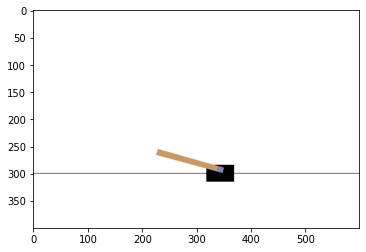

In [8]:
from utils import init_render, plot_step

env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()

img = init_render(env)

try:
    for _ in range(1000):
        plot_step(env, img)
        env.step(env.action_space.sample()) # take a random action
except KeyboardInterrupt:
    print('Interrupted')

env.close()

Vrátíme se zpět k *MountainCar*. Zkusíme do kódu výše připsat obecnou třídu pro agenta, který se v prostředí chová náhodně. Lze ho později použít jako základ pro zpětnovazebního agenta. Stav agenta je pozice a rychlost, akce může být pohyb vlevo, vpravo a nebo se nepohnout. Budeme opakovat několik iterací pro trénovaní, kdy každá iterace for cyklu je jedna hra s novým náhodným začátkem (kolem minima) a ve while cyklu se trénují přechody mezi stavy agenta.

In [4]:
import importlib
importlib.reload(utils)
import utils

In [3]:
from solution import QLearningAgent, StateDiscretizer

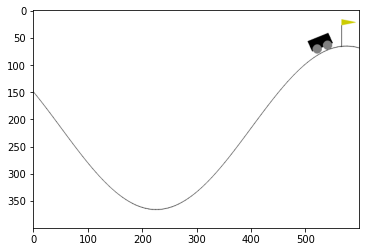

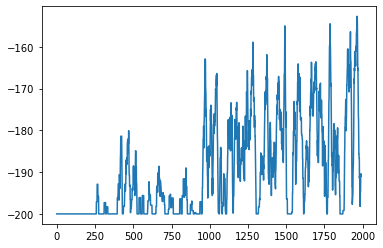

In [80]:
from tqdm import tqdm

# Obecna trida pro agenta
class RandomAgent:
    def __init__(self, actions):
        self.actions = actions
        self.train = True
    
    def act(self, observe, reward, done):
        return self.actions.sample()
    
    def reset(self):
        pass

env = gym.make('MountainCar-v0', render_mode="rgb_array")

# Zde si jen pro zajimavost vypiseme prostor pozorovani a akci
print('observation space:', env.observation_space)
print('observation space low:', env.observation_space.low)
print('observation space high:', env.observation_space.high)
print('action space:', env.action_space, flush=True)


st = StateDiscretizer(list(zip(env.observation_space.low, env.observation_space.high)), [15, 15])

#agent = RandomAgent(env.action_space)
agent = QLearningAgent(env.action_space, st, train=True)
total_rewards = []
for i in tqdm(range(2000)):
    obs, info = env.reset()
    agent.reset()    
    done = False
    terminated = False
    
    r = 0
    R = 0 # celkova odmena - jen pro logovani
    t = 0 # cislo kroku - jen pro logovani
    
    while not (done or terminated):
        action = agent.act(obs, r, done or terminated)
        # in docs, different naming
        obs, r, done, terminated, _ = env.step(action)  # done ... nasel finalni stav; terminated ... skoncil driv
        R += r
        t += 1
        
    total_rewards.append(R)    
agent.train = False

# Zobrazime si animaci a graf uceni
plt.figure()

try:
    env.reset()
    agent.train = False
    utils.show_animation(agent, env, steps=200, episodes=5)
except KeyboardInterrupt:
    print('interrupted')
finally:
    plt.show()

plt.plot(utils.moving_average(total_rewards, 10))
plt.show() 

env.close()

Když se podíváme na maximální hodnoty Q, některé stavy mají maximum 0 - agent v nich nejspíš ještě nebyl. Může to být například kvůli různým startovním pozicím.

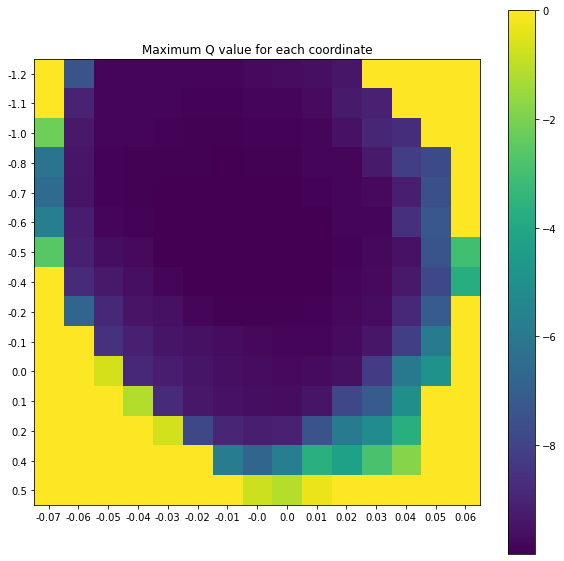

In [76]:
# let's look at max values of Q
plt.figure(figsize=(10, 10))
plt.title("Maximum Q value for each coordinate")
plt.imshow(agent.Q.max(axis=1).reshape(15, 15))
plt.xticks(np.arange(15), st.bins[1].round(2).tolist()[:-1])
plt.yticks(np.arange(15), st.bins[0].round(1).tolist()[:-1])
plt.colorbar()
plt.show()

Vidíme, že největší rozptyl hodnot je pro stavy, kde má agent nějakou větší rychlost (obzvláště směrem doprava) - tam je velký rozptyl Q hodnot (některé akce jsou o dost lepší než jiné)

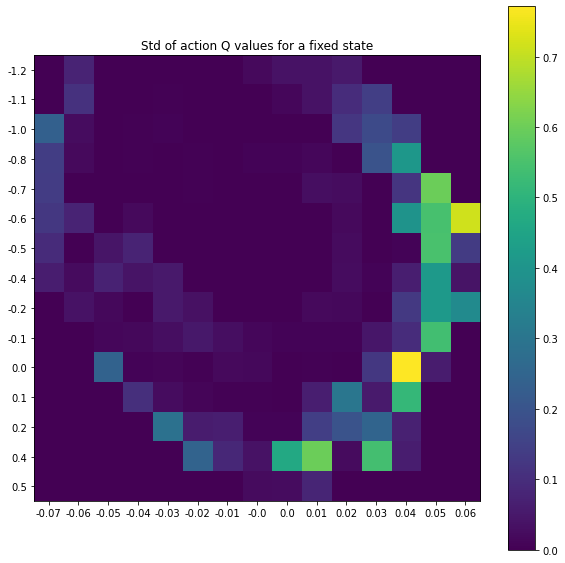

In [78]:
plt.figure(figsize=(10, 10))
plt.title("Std of action Q values for a fixed state")
plt.imshow(agent.Q.std(axis=1).reshape(15, 15))
plt.xticks(np.arange(15), st.bins[1].round(2).tolist()[:-1])
plt.yticks(np.arange(15), st.bins[0].round(1).tolist()[:-1])
plt.colorbar()
plt.show()

Z hlediska preferencí akcí, pokud agent má velkou rychlost doprava, chceme, aby dál zrychloval doprava (žlutá). Oproti tomu, při větší rychlosti doleva po něm chceme, aby nepřidával ani na jednu stranu (tyrkysová), nebo dokonce aby jel doprava (žlutá). doleva má jet pouze v několika případech (tmavě modrá).

Když se podíváte agenta, na levý kopec se spíš vynese díky zrychlení pro jízdu doprava. Můžeme se podívat znovu na jednu epizodu (v title si zobrazíme aktuální zvolenou akci)

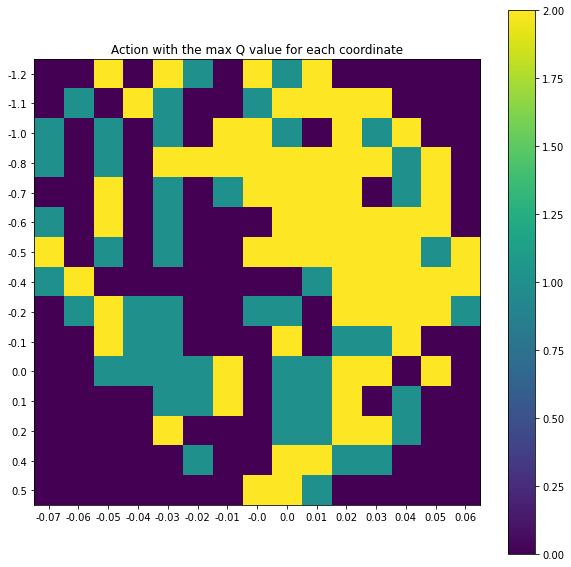

In [89]:
# 2 ... go right, 1 ... stay, 0 ... go left
# Left side 
plt.figure(figsize=(10, 10))
plt.title("Action with the max Q value for each coordinate")
plt.imshow(agent.Q.argmax(axis=1).reshape(15, 15))
plt.xticks(np.arange(15), st.bins[1].round(2).tolist()[:-1])
plt.yticks(np.arange(15), st.bins[0].round(1).tolist()[:-1])
plt.colorbar()
plt.show()

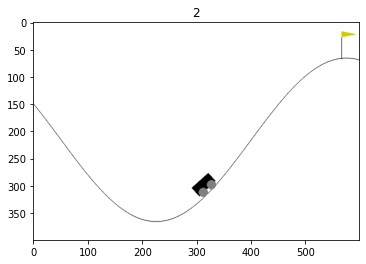

In [90]:
obs, info = env.reset()
agent.reset()    
done = False
terminated = False

r = 0
R = 0 # celkova odmena - jen pro logovani
t = 0 # cislo kroku - jen pro logovani

img = init_render(env)
while not (done or terminated):
    plot_step(env, img)
    action = agent.act(obs, r, done or terminated)
    # in docs, different naming
    obs, r, done, terminated, _ = env.step(action)  # done ... nasel finalni stav; terminated ... skoncil driv
    R += r
    t += 1
    plt.title(action)

## Úkol na cvičení

Zkuste si místo náhodného agenta naprogramovat třídu agenta, který se učí chovat v prostředí MountainCar pomocí Q-učení. Dejte pozor na to, že prostředí vrací jako stav spojité hodnoty, takže je třeba si z nich nějak udělat prostředí diskrétní (tedy s konečným množstvím stavů). Může se hodit np.linspace a np.digitize.

Zkuste řešení implementovat v souboru q_agent.py, a importovat jeho třídu tak, jako v utils.